In [3]:
from IPython.display import IFrame
#A few imports we will need later
from xlwings import Workbook, Sheet, Range, Chart
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.tools as tlsM
from IPython.display import HTML
from plotly.graph_objs import *
from IPython.display import Image 

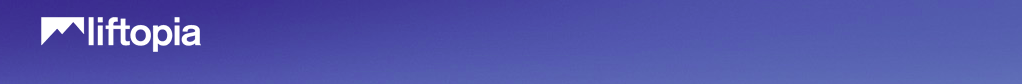

In [4]:
Image(filename='assets/logo.png')

## Building Interactive Graphs at the Push of an (Excel) Button Using Plot.ly and XLWings
_____________________________________

At [Liftopia](http://www.liftopia.com/) we are working on bringing dynamic pricing into the ski industry. We help consumers ski more by offering tickets for purchase in advance at lower prices in exchange for their commitment. We help resorts control their pricing, drive more predictable revenue and grow their businesses. 

Since one of our core business channels is pricing and selling lift tickets we spend a lot of time thinking about how to determine the way to price tickets throughout the season. Once we have a good plan built, we need to think about how to communicate the plan. With a dynamic pricing plan there's often a lot of data to communicate... The ski areas we work with often offer tickets on 120 days of the year at upwards of 10 different price points on each day of the season. If you do the math - that can mean trying to communicate 1,200 different prices for one product. Some resorts offer over 10 different products. Now we are at 12,000 data points. 

In an effort to communicate our pricing plans more effecitvely - we decided to use [Plot.ly](Plot.ly) to help us build web based interactive visualizations we can share with our partners. To do this we connected one of our pricing tools to a python script that interacts with Plotly's API. 

This notebook walks through a simplified version of that process. Note - the data used in this example is intended to show how we use Plotly from Excel - if you want to talk to us about our beliefs abour pricing - get in touch! (ostegmaier@liftopia.com) 

### How can we go from this: 

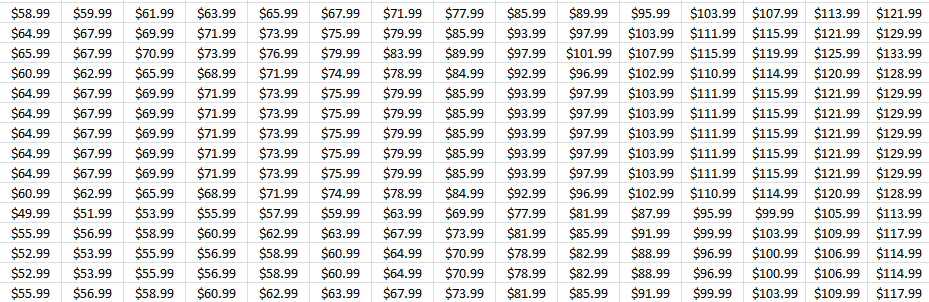

In [5]:
Image(filename='assets/prices.png')

###To this: 

In [6]:
IFrame('https://plot.ly/~otto.stegmaier/609/previous-min-and-max-prices/', width=1000, height=500)

___________________________


## Step 1 Connect to your data in Excel using XLWings
______________________________

To show how we use plotly with XLWings and Excel - we put together some simulated data in an excel workbook. For more on XLWings Check out their [documentation](http://docs.xlwings.org/api.html) or this [great tutorial](https://www.youtube.com/watch?v=Z80kyLcG6JI)

In [3]:
#workbook connection - When connecting to a file from a VBA macro you use Workbook.call() instead of Workbook(<filepath>)
wb = Workbook('Example Workbook.xlsm')

##Using Excel as a Plotly Dashboard...

Ok - so maybe its not so high speed - but its a good fit for our users! Plotly has a ton of great GUI tools to edit the graphs once they're made, but we needed a way to make it easy on our users to get the graphs out of excel and into Plotly so they can edit the graphs there. So we build a "Dashboard" with some controls:



<img src="https://raw.githubusercontent.com/ostegm/Plotly_Post/master/assets/dashboard.png" width="700" />
_________________
###Now we can use some of these user-input values to control what elements get plotted 


In [4]:
#Now we can use some of these controls to customize the 
folder_name = Range('Dashboard','B2').value
graph_title = Range('Dashboard','B3').value

### Next we will use the user input to create some dataframes for each sheet the user wants to plot

In [5]:
#short function to create a new dataframe using xlwings
def new_df(shtnm, startcell = 'A1'):
    data = Range(shtnm, startcell).table.value
    temp_df = pd.DataFrame(data[1:], columns = data[0])
    return(temp_df)

###Make some dataframes from the workbook sheets
#Core Product
shtnm1 = Range('Dashboard','B6').value
df = new_df(shtnm1)

#2nd Product
product_2 = False
if Range('Dashboard','C7').value == "Yes":
    shtnm2 = Range('Dashboard','B7').value
    df2 = new_df(shtnm2)
    product_2 = True

#3rd Product
product_3 = False
if Range('Dashboard','C8').value == "Yes":
    shtnm3 = Range('Dashboard','B8').value
    df3 = new_df(shtnm3)
    product_3 = True       

### Its easier to work with the column headers once they're cleaned up, so let's clean them up a bit

In [6]:
#Clean up the charaters in the columns 
names2 = []
def clean_names(column_list):
    #Short function to make our column headers easier to reference later.
    names2=[]
    for name in column_list:
        name = name.replace(" ","").lower()
        if 'windowprice' in name: #this allows non-adult ticket types to be built
            name = 'windowprice'
        names2.append(name)
    return names2

df.columns = clean_names(df.columns.values)
if product_2 == True:
    df2.columns = clean_names(df2.columns.values)
if product_3 == True:
    df3.columns = clean_names(df3.columns.values)  

###We found it useful to be using a common index across the products - at least for our purpose, so we reset the index on the date column and convert the rest of the data to float

In [7]:
df= df.set_index('date').tz_localize('MST').astype(float)
if product_2 == True:
    df2= df2.set_index('date').tz_localize('MST').astype(float)
if product_3 == True:
    df3= df3.set_index('date').tz_localize('MST').astype(float)

###To help make our graph look good, we need some global variable set. 
-Remember though, even if it looks wierd when plotted, the user can always go edit the plot on Plotly's web based tool

In [8]:
#set a few global variables so we can use them throughout the plots
X = df.index

try:  
    ymin = min(df['minpriceoffered'].min(),df2['minpriceoffered'].min(),df3['minpriceoffered'].min()) - 10
    ymax = max(df['walkupprice'].max(),df2['walkupprice'].max(),df3['walkupprice'].max()) + 10
    
except:
    #If that doesn't work, just go edit it on Plotly's web based plot editor. 
    ymin = df['minpriceoffered'].min() - 10
    ymax = df['walkupprice'].max() + 10

###For our particular use case - we were rebuilding traces of similar type,  so we wrote a short function to simplify this step

In [9]:
#function to create a "trace" (line) for each item we want to plot
def new_trace(price_column, color, name, x=X, fill = 'none', qty_column = []):
    trace = Scatter(
    x=X,
    y=price_column,  
    fill=fill,
    mode='lines',
    name=name,
    text=['Quantity: {}'.format(q) for q in qty_column],
    line=Line(
        color=color,
        width=2,
        dash='solid',
        opacity=1,),
    xaxis='x1',
    yaxis='y1')
    return trace

#Set up the 3 core traces
trace1 = new_trace(df['walkupprice'], '#FF9966','Core Product Walkup Price') 
trace2 = new_trace(df['maxpriceoffered'], '#5EA5D1',shtnm1 + 'Highest Price Offered', qty_column=df['unitsmax']) 
trace3 = new_trace(df['minpriceoffered'], '#5EA5D1',shtnm1+' Starting Price',  qty_column= df['unitsmin'], fill='tonexty') 
trace_list = [trace1, trace2, trace3]

###Next we can add in the additional products if the user selected yes in the Excel Dashboard Sheet

<img src="https://raw.githubusercontent.com/ostegm/Plotly_Post/master/assets/toggle.png" width="700" />

In [10]:
#add additional traces if toggled on by user
if product_2 == True:
    trace4 = new_trace(df2['minpriceoffered'], '##66ff66',shtnm2+' Lowest Price Offered')
    trace_list.append(trace4)  

if product_3 == True:
    trace5 = new_trace(df3['minpriceoffered'], '#e6e600',shtnm3+' Lowest Price Offered') 
    trace_list.append(trace5) 
    

### Lastly we set some general Layout controls. 
If needed, these could be added as user controls pretty easily in the Excel dashboard - or you could just edit the graph from Plotly's GUI.

In [11]:
layout = Layout(
    title=graph_title,                #Using the input from the Dashboard Sheet in Excel
    titlefont=Font(
        size=12.0,
        color='#262626'
    ),
    showlegend=True,
    hovermode='compare',
    xaxis1=XAxis(
        title='Trip Date',
        titlefont=Font(
            size=11.0,
            color='#262626'
        ),
        range=[X.min(),X.max()],
        domain=[0.0, 1.0],
        type='date',
        showgrid=True,
        zeroline=False,
        showline=True,
        nticks=8,
        ticks='inside',
        tickfont=Font(
            size=10.0
        ),
        mirror='ticks',
        anchor='y1',
        side='bottom'
    ),
    yaxis1=YAxis(
        title='Price',
        titlefont=Font(
            size=11.0,
            color='#262626'
        ),
        range=[ymin, ymax],
        domain=[0.0, 1.0],
        type='linear',
        showgrid=True,
        zeroline=False,
        showline=True,
        nticks=7,
        ticks='inside',
        tickfont=Font(
            size=10.0
        ),
        mirror='ticks',
        anchor='x1',
        side='left'
    )
)

In [12]:
#Short function for pushing private graphs to plotly
def private_plot(*args, **kwargs):
    kwargs['auto_open'] = False     #Controls whether a new tab is opened in your browser with the new plot
    url = py.plot(*args, **kwargs)
    return (url)

### Now We are ready to plot! 

In [13]:
fig = Figure(data=trace_list, layout=layout)
url = private_plot(fig,  filename='%s/%s' %(folder_name, graph_title), world_readable=True)
print url 
IFrame(url, width=700, height=350)

https://plot.ly/~otto.stegmaier/609


C:\Anaconda\lib\site-packages\requests\packages\urllib3\util\ssl_.py:90: InsecurePlatformWarning:

A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.



________________
__________________
## Now that the code is working, how to run this dirctly from Excel?
________________
________________

#### Save the python script to file. Make sure to use Workbook.caller() rather than the file path. This allows XLWings to access the current notebook that the user has open.
________________
<img src="https://raw.githubusercontent.com/ostegm/Plotly_Post/master/assets/workbookcaller.png" width="400" />
________________
####Build a Macro in python that references the script you've written:
________________
<img src="https://raw.githubusercontent.com/ostegm/Plotly_Post/master/assets/macro.png" width="700" />
________________
####Assign the macro to a button of your choosing
________________
<img src="https://raw.githubusercontent.com/ostegm/Plotly_Post/master/assets/assignmacro.png" width="500" />
________________
#### Make any final edits using Plotly's web based editor
________________
<img src="https://raw.githubusercontent.com/ostegm/Plotly_Post/master/assets/plotlyeditor.png" width="800" />

__________________
Thanks for reading this far! 